This notebook gives a Python implementation of  [Introduction to Statistical Learning with R Applications](https://www.statlearning.com/) Chapter 10. The chapter discusses a Neural Networks and Deep Learning, with a lab implementing a series of tensorflow models.

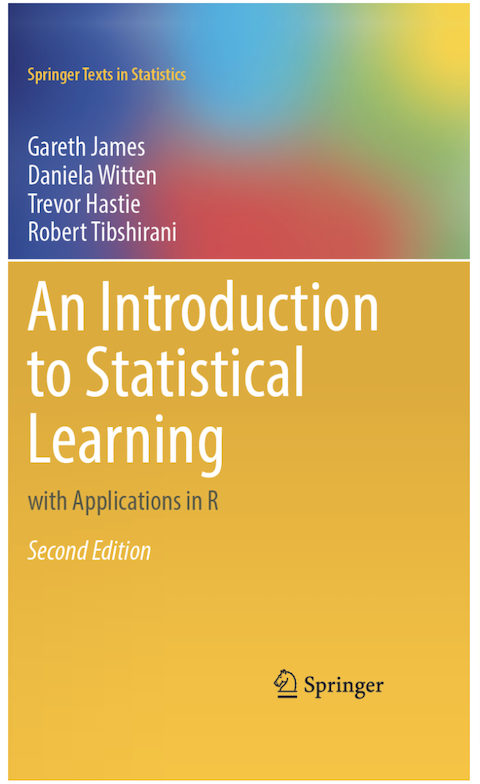

The R version can be found [here](https://www.statlearning.com/resources-second-edition). I implemented the lab in Python trying to follow step-by-step what the authors propose in their book and [course](https://learning.edx.org/course/course-v1:StanfordOnline+STATSX0001+1T2022/). Sharing here in case it is useful to anyone else.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Single Layer Network on Hitters Data

In [ ]:
df = pd.read_csv("Hitters.csv")

In [ ]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
df = df.dropna()

In [ ]:
n_row = df.shape[0]
n_row

263

In [ ]:
# Create OneHot Encoded Variables - Just like R would do
df = pd.get_dummies(df, columns=['Division', 'League', 'NewLeague'])

In [ ]:
# Split into Train/Test
test = df.sample(int(n_row/3), random_state = 13)
train = df.drop(test.index)

In [ ]:
train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,Division_E,Division_W,League_A,League_N,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,0,1,1,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,1,0,0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,1,0,0,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,0,1,1,0,1,0


In [ ]:
test.shape

(87, 23)

In [ ]:
train.shape

(176, 23)

## Linear Regression Model - Baseline

In [ ]:
linear_model = LinearRegression().fit(train.drop("Salary", axis=1), train["Salary"])

In [ ]:
# Predict

pred = linear_model.predict(test.drop("Salary", axis=1))

In [ ]:
# Calculate error - MAE

np.mean(np.abs(test['Salary'] - pred))

242.9928279356144

## TensorFlow and Keras

In [ ]:
# The tf.keras.model.Sequential module is just a Feed Forward Network
# Here we are just creating the network layout

# We create one hidden layer with 50 units. The input shape is the number of
# columns of X. The activation function for these
# units is Rectified Linear (relu). We are adding a Dropout regularization,
# where we drop random nodes with probability 0.4 and scale the remaining
# nodes by 1/(1 - 0.4).
# Final layer is the output layer.

tf_model =  tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(22,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

In [ ]:
print(tf_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                1150      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Here we configure and compile our NN model

# We are setting mse as loss function
# The optimizer is rmsprop - a type of stochastic Gradient Descent
# Our metric is MAE

tf_model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mean_absolute_error'])

In [ ]:
# Batch size is 32, that means that 32 random rows
# will be selected at every step of gradient descent
# Epochs is 600, this is how many passes we will do in our data.

# Notice that, as the example in the course, we are validating with the test
# data, so the test error could be a undersestimate of the prediction error.

tf_model.fit(train.drop("Salary", axis=1),
             train["Salary"],
             epochs=600,
             batch_size=32,
             validation_data=[test.drop("Salary", axis=1),
                              test["Salary"]])

In [ ]:
# Predict

tf_pred = tf_model.predict(test.drop("Salary", axis=1))

3/3 [==============================] - 0s 3ms/step


In [ ]:
# Calculate error - MAE

np.mean(np.abs(test['Salary'] - tf_pred.flatten()))

160.9841163815904

# Multilayer Network on the MNIST Digit Data

In [2]:
# Load MNIST data

mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
print(x_train.shape, x_test.shape, y_train.shape)

(60000, 28, 28) (10000, 28, 28) (60000,)


In [8]:
# Flatten the pictures - make the 28 by 28 matrices into arrays

x_test = x_test.reshape(x_test.shape[0], 28*28)
x_train = x_train.reshape(x_train.shape[0], 28*28)

In [9]:
x_train.shape

(60000, 784)

In [10]:
# Scaling variables - NNs are sensitives to the scale of your data.
# Here we are scaling our numbers so they lie in the range of 0 to 1.
# we do that by doing X - min / Max - Min. The scale of our input
# is from 0 to 255, so that basically gives us:

x_train = x_train/255
x_test = x_test/255

In [13]:
# Model layout setup

# We will create a FeedForward Network with 2 layers (DeepLearning)
# One hidden layer has 256 units and the other layer 128

tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation="relu", input_shape=(784,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [15]:
print(tf_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
